# 机器学习 实验二

**题目：回归模型**  
实验条件：给定数据集 winequality-wine.csv  
实验要求：  
1. 基本要求：构造线性回归模型。
   - 按照4:1划分为训练集和测试集，尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式
   - 采用批量梯度下降**和**随机梯度下降进行优化
   - 输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线
   - 采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率
2. 中级要求：探究回归模型在机器学习和统计学上的差异。
3. 高级要求：编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法**均可**）。

# 导入需要的包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# 数据预处理

In [2]:
data = pd.read_csv('./winequality-white.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


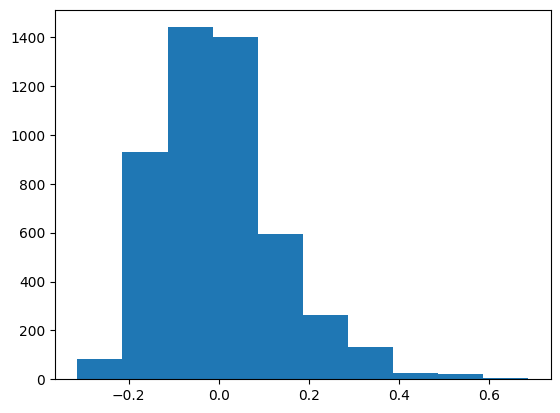

In [3]:
# 中心化
def Normalization_fun(x):
    # 特征零均值
    x = (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

# 提取特征和标签
data.iloc[:, 0:-1] = Normalization_fun(data.iloc[:,0:-1])
# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在左侧添加全为1的一列
data = pd.concat([pd.DataFrame(np.ones(data.shape[0]), columns=['x0']), data], axis=1)

# 可视化中心化后的 sulphates 特征
plt.hist(data["sulphates"])
plt.show()

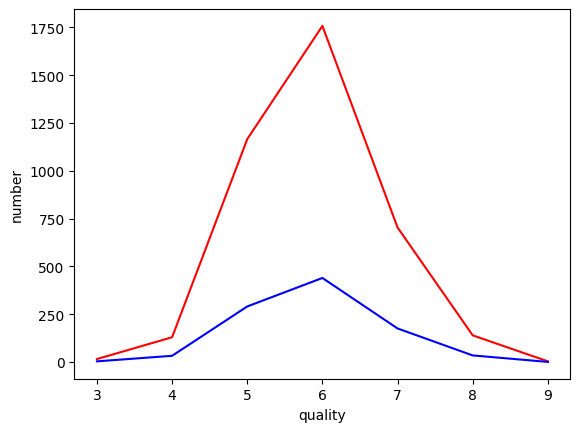

In [4]:
# 分层采样划分训练集和测试集
train_data = data.groupby('quality').apply(lambda group: group.sample(frac = 0.8))
train_data.index = train_data.index.droplevel()
test_data = data[~data.index.isin(train_data.index)]

# 重置索引
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# 抽样结果
quality_index = range(3,10)
train_sample_res = train_data['quality'].value_counts()[quality_index]
test_sample_res = test_data['quality'].value_counts()[quality_index]
plt.figure()
plt.plot(quality_index, train_sample_res, 'r')
plt.plot(quality_index, test_sample_res, 'b')
plt.xlabel('quality')
plt.ylabel('number')
plt.show()

In [5]:
x_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
x_test = test_data.iloc[:,0:-1]
y_test = test_data.iloc[:,-1]
#print(x_train)

# 转换为 numpy.ndarray 格式
x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1)
x_test = np.array(x_test)
y_test = np.array(y_test).reshape(-1,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3918, 12) (3918, 1) (980, 12) (980, 1)


# 基础要求：线性回归

In [6]:
# 初始化回归系数
W_init = np.random.randn(x_train.shape[1], 1)
W_init

array([[ 0.80708932],
       [-0.28693233],
       [-1.77130246],
       [-0.04066516],
       [ 1.41431695],
       [ 1.25094905],
       [-0.36481751],
       [ 0.48295893],
       [-1.3712637 ],
       [-1.53522529],
       [-0.25552498],
       [ 0.42330426]])

In [7]:
# 定义均方误差
def MSE(x, y, w):
    return np.sum(np.power((np.dot(x,w)-y),2))/y.size

## 批量梯度下降  
$$\theta_{j}=\theta_{j}+\alpha\frac{1}{m}(y-X\theta)^{T}x_{j}$$

In [25]:
def BGD(x_train, y_train, x_test, y_test, theta, alpha, epochs):
    theta = copy.deepcopy(theta)
    m = y_train.size
    t = theta.size
    train_loss = []
    test_loss = []
    train_loss.append(MSE(x_train, y_train, theta))
    test_loss.append(MSE(x_test, y_test, theta))
    for i in range(epochs):
        for j in range(t):
            x_j = x_train[:, j].reshape(-1,1)
            theta[j] = theta[j] + alpha * np.sum((y_train - np.dot(x_train, theta)) * x_j) / m
        train_loss.append(MSE(x_train, y_train, theta))
        test_loss.append(MSE(x_test, y_test, theta))
    return theta, train_loss, test_loss

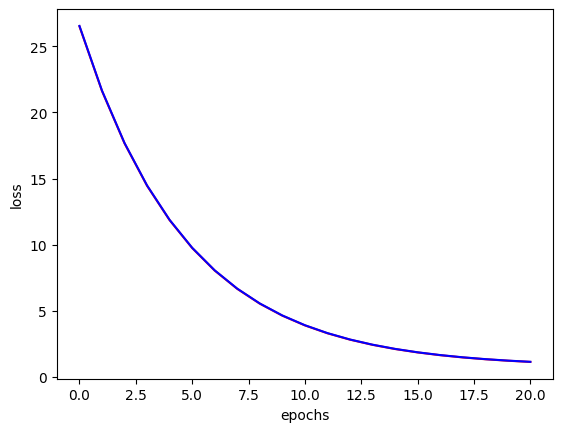

[[ 5.26119894]
 [-0.31076637]
 [-1.77788292]
 [-0.04976652]
 [ 1.39320111]
 [ 1.22089115]
 [-0.36504473]
 [ 0.45704053]
 [-1.39983516]
 [-1.45931156]
 [-0.23022562]
 [ 0.5562889 ]]


In [9]:
alpha = 0.1
epochs = 20
BGD_theta, BGD_train_loss, BGD_test_loss = BGD(x_train, y_train, x_test, y_test, W_init, alpha, epochs)
plt.figure()
epoch_index = range(epochs+1)
plt.plot(epoch_index, BGD_train_loss, 'r')
plt.plot(epoch_index, BGD_test_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print(BGD_theta)

## 随机梯度下降
$$for\ i=1\ to\ m:$$  
$$\theta_{j}=\theta_{j}+\alpha(y^{i}-h_{\theta}(x^{i}))x_{j}^{i}$$

In [37]:
def SGD(x_train, y_train, x_test, y_test, theta, alpha, epochs):
    theta = copy.deepcopy(theta)
    x_train = copy.deepcopy(x_train)
    m = y_train.size
    t = theta.size
    train_loss = []
    test_loss = []
    train_loss.append(MSE(x_train, y_train, theta))
    test_loss.append(MSE(x_test, y_test, theta))
    for i in range(epochs):
        rand_i = np.random.randint(m)
        x_i = x_train[rand_i, :].reshape(1,-1)
        y_i = y_train[rand_i, :].reshape(-1, 1)
        for j in range(t):
            x_ij = x_train[rand_i, j].reshape(-1,1)
            theta[j] = theta[j] + alpha * np.sum((y_i - np.dot(x_i, theta)) * x_ij)
        train_loss.append(MSE(x_train, y_train, theta))
        test_loss.append(MSE(x_test, y_test, theta))
    return theta, train_loss, test_loss

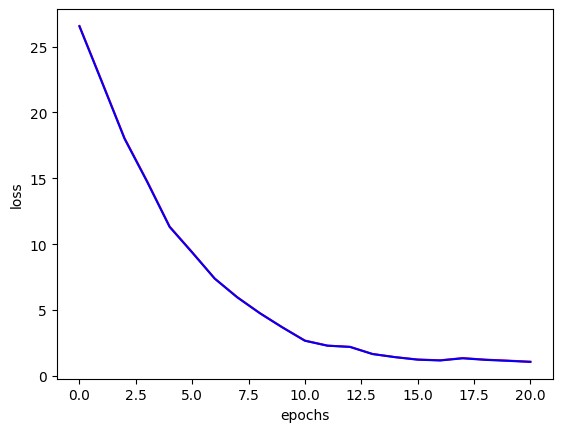

[[ 5.40330445]
 [-0.29292537]
 [-1.61338189]
 [ 0.09334485]
 [ 1.56891412]
 [ 1.30984401]
 [-0.3770116 ]
 [ 0.53112021]
 [-1.24884802]
 [-1.42817301]
 [-0.03294301]
 [ 0.24763476]]


In [43]:
alpha = 0.1
epochs = 20
SGD_theta, SGD_train_loss, SGD_test_loss = SGD(x_train, y_train, x_test, y_test, W_init, alpha, epochs)
plt.figure()
epoch_index = range(epochs+1)
plt.plot(epoch_index, SGD_train_loss, 'r')
plt.plot(epoch_index, SGD_test_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print(SGD_theta)

## 探究最佳学习率

In [46]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1]
epochs = 30
BGD_train_losses = []
BGD_test_losses = []
SGD_train_losses = []
SGD_test_losses = []
for alpha in alphas:
    BGD_theta, BGD_train_loss, BGD_test_loss = BGD(x_train, y_train, x_test, y_test, W_init, alpha, epochs)
    SGD_theta, SGD_train_loss, SGD_test_loss = SGD(x_train, y_train, x_test, y_test, W_init, alpha, epochs)
    BGD_train_losses.append(BGD_train_loss)
    BGD_test_losses.append(BGD_test_loss)
    SGD_train_losses.append(SGD_train_loss)
    SGD_test_losses.append(SGD_test_loss)

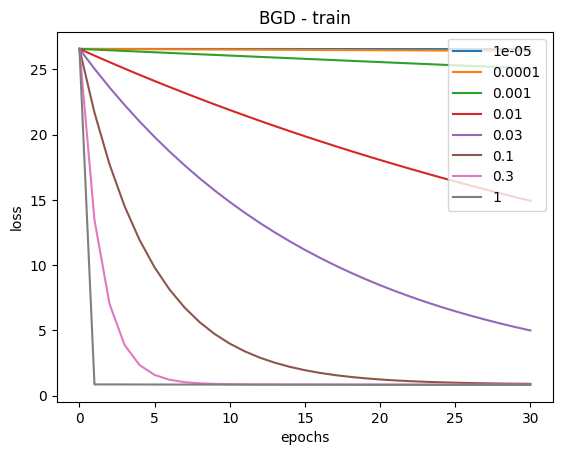

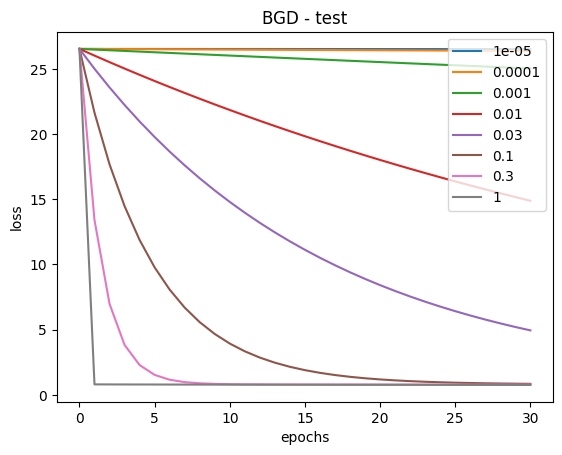

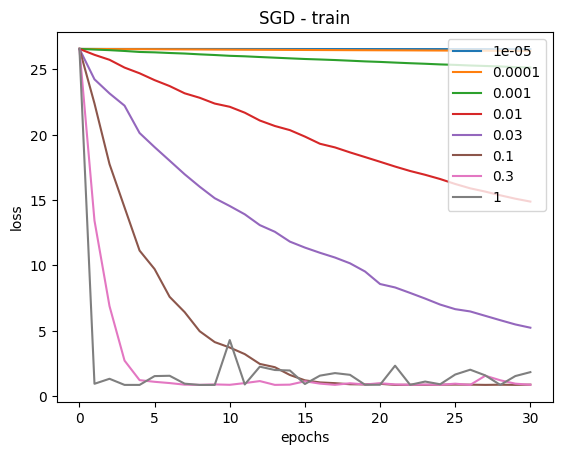

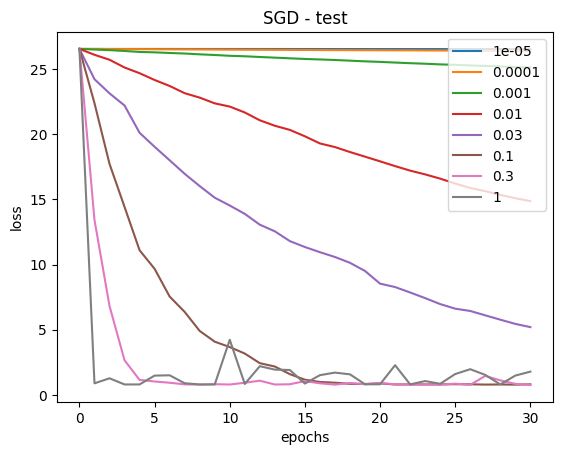

In [47]:
epoch_index = range(epochs+1)
plt.figure()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('BGD - train')
for i in range(len(alphas)):
    plt.plot(epoch_index, BGD_train_losses[i])
plt.legend(alphas, loc='upper right')

plt.figure()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('BGD - test')
for i in range(len(alphas)):
    plt.plot(epoch_index, BGD_test_losses[i])
plt.legend(alphas, loc='upper right')

plt.figure()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('SGD - train')
for i in range(len(alphas)):
    plt.plot(epoch_index, SGD_train_losses[i])
plt.legend(alphas, loc='upper right')

plt.figure()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('SGD - test')
for i in range(len(alphas)):
    plt.plot(epoch_index, SGD_test_losses[i])
plt.legend(alphas, loc='upper right')

由上述结果可知：  
1. 对批量梯度下降回归，学习率过高会导致过拟合，过低会导致欠拟合，最佳学习率约在 0.1-0.3 之间；且，随着迭代次数增加，MSE 稳定地下降，最佳学习率区间内最终收敛在大致相同的地方。
2. 对随机梯度下降回归，最佳学习率也约在 0.1-0.3 之间；学习率较高时，能迅速收敛，但在收敛后出现持续波动。

# 中级要求

**回归模型在机器学习和统计学上的差异**  

1. 目的

机器学习只看重结果（即获得最高的预测准确率），而它是如何实现的、模型是否可解释并不在关心范围内；统计学更多地注重挖掘变量之间的关系，以数学方程式作为这种关系的程式化表达，称为统计推断。

2. 过程

机器学习中，我们使用数据的一个子集作为训练集，反复迭代直至损失收敛，即在测试集上获得最好的预测性能；统计模型上，我们只要找到可以最小化所有数据的均方误差（假设数据是线性回归量，加上随机噪声），无需训练和测试。

3. 机器学习是基于统计学的  

尽管不是所有机器学习算法都有良好的统计特性，但在回归模型上，我们的确可以做假设检验；在这点上，可以说机器学习是统计学在面对大样本数据时的工程实践，其正确性需要统计学理论来支撑。

# 高级要求：岭回归
$$\theta=(x^{T}x+\lambda I)^{-1}x^{T}y$$

In [14]:
def RidgeLoss(x, y, w, L2=0.01):
    MSE = np.sum(np.power((np.dot(x,w)-y),2))/y.size
    L2_loss = np.sum([i for i in w]) * L2
    return MSE + L2_loss

In [17]:
def Ridge(x_train, y_train, L2=0.01):
    x_mat = np.mat(x_train)
    y_mat = np.mat(y_train)
    rxTx = x_mat.T * x_mat + np.eye(x_mat.shape[1]) * L2
    if np.linalg.det(rxTx)  == 0:
        print("This matrix cannot inverse.")
        return
    else:
        return rxTx.I * x_mat.T * y_mat

In [18]:
Ridge_theta = Ridge(x_train, y_train, )
train_loss = RidgeLoss(x_train, y_train, Ridge_theta)
test_loss = RidgeLoss(x_test, y_test, Ridge_theta)
print("average train loss: ",train_loss)
print("average test loss: ",test_loss)

average train loss:  0.6011148485742698
average test loss:  0.6132719028640244
